# Processing the results of the experiment

In [100]:
import importlib
import utils
importlib.reload(utils) # Reload instead of using cached version

# Imports
import pandas as pd
import glob
from pathlib import Path
import os
import subprocess
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Make sure we're using python 3.10.1 (same as version on short)
!python3 --version

Python 3.10.1


## Setup

In [101]:
# Set root to git subfolder
git_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
os.chdir(git_root)

In [102]:
RESULT_DIR = "fitness_variance_investigation/results"

In [103]:
def understand_outliers(combined_np_array):
    def get_outliers():
        # Get outliers
        Q1 = np.quantile(combined_np_array, 0.25)
        Q3 = np.quantile(combined_np_array, 0.75)
        IQR = Q3 - Q1
        outliers = combined_np_array[(combined_np_array < Q1 - 1.5 * IQR) | (combined_np_array > Q3 + 1.5 * IQR)]
        return outliers

    outliers = get_outliers()

    print(f"There are {len(outliers)} outliers, so {len(outliers) * 100 / len(combined_np_array):.2f}% of the data is outliers")

    # Percentage difference from median
    if len(outliers) > 0:
        average_outlier_magnitude = ((outliers / np.median(combined_np_array)) - 1) * 100
        print(f"Average outlier magnitude: {np.mean(average_outlier_magnitude):.2f}%")

Lets first extract all the experiments and trial (folds)

In [104]:
get_root_name = lambda path : path.split("/")[-2]

df = pd.DataFrame()

# Loop through all the search algorithms
program_types = glob.glob(RESULT_DIR + "/*/")
for program_type in program_types:
    path_log = program_type + "logs/"
    new_row = pd.DataFrame([{"program": get_root_name(program_type), "path_log": path_log}])
    df = pd.concat([df, new_row], ignore_index=True)
df

,program,path_log
0,triangle,fitness_variance_investigation/results/triangl...
1,minisat,fitness_variance_investigation/results/minisat...


## Preprocessing

In [105]:
# Extract Pickle Object
df['pkl_obj'] = df['path_log'].apply(utils.generate_pickle_object)

# Extract Warmup Values
df['warmup_values'] = df['pkl_obj'].apply(lambda x: np.array(x['warmup_values']))

# Subtract median to get a better visualisation
# df['warmup_values'] = df['warmup_values'].apply(lambda x: x - np.median(x))


## Analysis -- Warmup Consistency

### Triangle Program

First we explore the variance of the warmup phase. For our experiment, we used to perf function in hopes of minimizing the variance of the warmup phase. The hope is that the variance of the warmup phase is small enough that we can ignore it. We will explore this assumption here.

In [106]:
warmup_values = df[df['program'] == 'triangle']['warmup_values'].iloc[0]
warmup_values

array([1204239, 1204240, 1204240, 1204238, 1204240, 1204240, 1204239,
       1204241, 1204239, 1204240, 1204239, 1204240, 1204239, 1204240,
       1204239, 1204240, 1204240, 1204240, 1204240, 1204239, 1204240,
       1204239, 1204241, 1204239, 1204240, 1204239, 1204240, 1204239,
       1204239, 1204238, 1204240, 1204239, 1204239, 1204239, 1204240,
       1204240, 1204240, 1204240, 1204239, 1204239, 1204239, 1204240,
       1204240, 1204239, 1204240, 1204240, 1204239, 1204241, 1204240,
       1204240, 1204240, 1204240, 1204239, 1204241, 1204239, 1204240,
       1204242, 1204241, 1204240, 1204239, 1204238, 1204240, 1204240,
       1204239, 1204239, 1204240, 1204239, 1204239, 1204240, 1204240,
       1204239, 1204239, 1204239, 1204239, 1204241, 1204239, 1204239,
       1204240, 1204239, 1204241, 1204239, 1204240, 1204241, 1204240,
       1204240, 1204240, 1204239, 1204238, 1204240, 1204240, 1204239,
       1204241, 1204239, 1204240, 1204239, 1204239, 1204240, 1204240,
       1204239, 1204

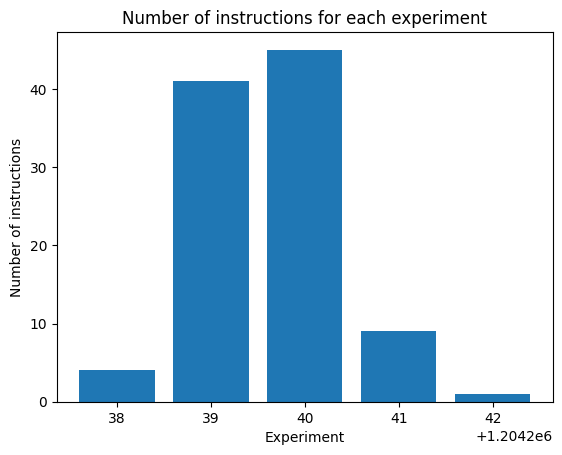

In [107]:
unique_values, counts = np.unique(warmup_values, return_counts=True)

plt.bar(unique_values, counts)
plt.title('Number of instructions for each experiment')
plt.xlabel('Experiment')
plt.ylabel('Number of instructions')
plt.show()


We notice that the perf function creates values that are very close together +- 1 instruction. We create a boxplot to better visualize the variance of the warmup phase.

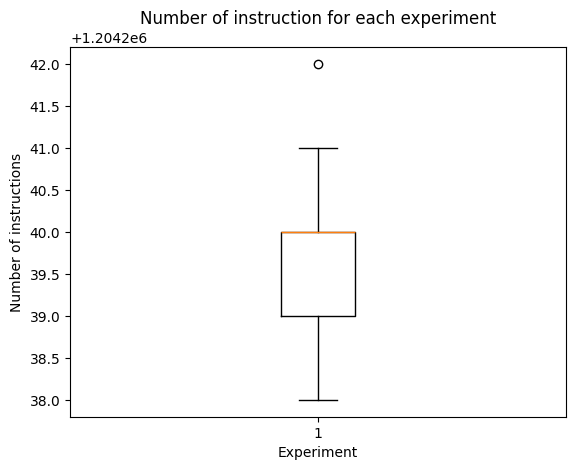

In [108]:
plt.boxplot(warmup_values)
plt.title('Number of instruction for each experiment')
plt.ylabel('Number of instructions')
plt.xlabel('Experiment')
plt.show()

In [109]:
understand_outliers(warmup_values)

There are 1 outliers, so 1.00% of the data is outliers
Average outlier magnitude: 0.00%


We notice that the variance is mostly consistent, however, often runs of this experiment lead to outliers where instruction count jumps as much as 20%. The explanation for this is difficult to replicate right now

### Minisat

We now do the same for minisat

In [110]:
warmup_values = df[df['program'] == 'minisat']['warmup_values'].iloc[0]
warmup_values

array([55206472829, 55206471787, 55206472191, 55206465445, 55206476658,
       55206458849, 55206471029, 55206465217, 55206470895, 55206472879,
       55206473031, 55206465509, 55206466410, 55206469798, 55206464224,
       55206471038, 55206470341, 55206469025, 55206465731, 55206478376,
       55206471401, 55206463582, 55206458837, 55206471078, 55206461619,
       55206450502, 55206460441, 55206466644, 55206460859, 55206455561,
       55206461961, 55206460360, 55206459258, 55206454485, 55206461275,
       55206459722, 55206466701, 55206465496, 55206466554, 55206463040,
       55206460823, 55206459926, 55206472152, 55206466740, 55206459929,
       55206466903, 55206466152, 55206465941, 55206466941, 55206468654,
       55206462249, 55206466823, 55206452702, 55206471109, 55206467992,
       55206464638, 55206467096, 55206459621, 55206460925, 55206460220,
       55206466341, 55206458139, 55206466209, 55206465478, 55206451883,
       55206465702, 55206469349, 55206462451, 55206467940, 55206

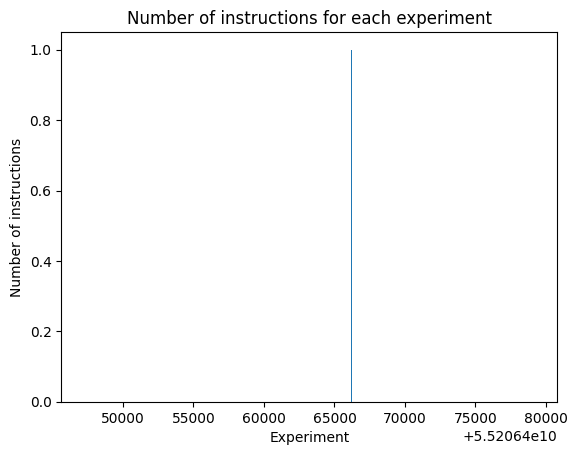

In [111]:
unique_values, counts = np.unique(warmup_values, return_counts=True)

plt.bar(unique_values, counts)
plt.title('Number of instructions for each experiment')
plt.xlabel('Experiment')
plt.ylabel('Number of instructions')
plt.show()

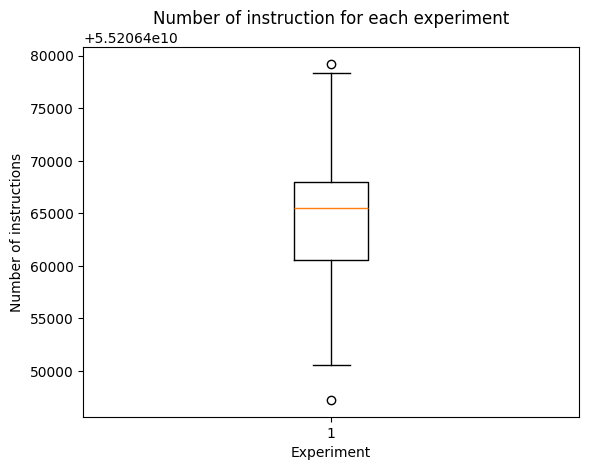

In [112]:
plt.boxplot(warmup_values)
plt.title('Number of instruction for each experiment')
plt.ylabel('Number of instructions')
plt.xlabel('Experiment')
plt.show()

In [113]:
understand_outliers(warmup_values)

There are 2 outliers, so 2.00% of the data is outliers
Average outlier magnitude: -0.00%
